## Bike Sharing Problem - Model building and inference

This notebook documents the analysis and model development for the Bike Sharing Dataset.

$\bf{Goal}$: To goal is to build a predictive model for the number of bike rides an hour based on time of year and weather. In particular we are interested in predicting the number of rides, cnt.

The characteristics of the given problem are

- Regression: The target variable is a quantity.
- Small dataset: Less than 20K samples.
- Few features should be important.
    * The correlation matrix indicates that a few features contain the information to predict the target variable.

It contains the following steps:
- Overview metrics
- Model building
- Model Selection
  * Linear Regession
  * Tree-based Ensemble Regression
  * Feature importance
- Model evaluation

In [424]:
## Loading required package
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import scipy.stats as stats

# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Sklearn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

# Sklearn untility functions
from sklearn.model_selection import train_test_split

# XGBoost, Catboost, and LightGBM models
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
import lightgbm as lgbm

# ARIMA
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

# Beautify evaluation tables
from prettytable import PrettyTable

np.random.seed(42)

In [425]:
# File path 
base_dir = '/Users/chrisjcc/Desktop/DataInsight/DataChallenge/Bike-Sharing-Dataset/'
data_path = base_dir + 'hour.csv'

# Load data
data = pd.read_csv(data_path, parse_dates=True, squeeze=True) 

In [426]:
# Quick check of proper loading of dataset
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [427]:
data.iloc[0]

instant                1
dteday        2011-01-01
season                 1
yr                     0
mnth                   1
hr                     0
holiday                0
weekday                6
workingday             0
weathersit             1
temp                0.24
atemp             0.2879
hum                 0.81
windspeed              0
casual                 3
registered            13
cnt                   16
Name: 0, dtype: object

In [428]:
data.iloc[12]

instant               13
dteday        2011-01-01
season                 1
yr                     0
mnth                   1
hr                    12
holiday                0
weekday                6
workingday             0
weathersit             1
temp                0.42
atemp             0.4242
hum                 0.77
windspeed         0.2836
casual                29
registered            55
cnt                   84
Name: 12, dtype: object

### Data Preparation

This step involves cleaning the data, dropping unwanted columns, converting the categorical variables to numeric, and finally splitting of training data into train and validation sets.

In [429]:
# Preprocessing: Renaming columns names to more readable names
data.rename(columns={'instant':'rec_id',
                     'dteday':'datetime',
                     'holiday':'is_holiday',
                     'workingday':'is_workingday',
                     'weathersit':'weather_condition',
                     'hum':'humidity',
                     'mnth':'month',
                     'cnt':'total_count',
                     'hr':'hour',
                     'yr':'year',
                    },inplace=True)

In [430]:
# Setting proper data types

# date time conversion
data['datetime'] = pd.to_datetime(data.datetime)

# categorical fetures
data['season']     = data.season.astype('category')
data['is_holiday'] = data.is_holiday.astype('category')
data['weekday']    = data.weekday.astype('category')
data['weather_condition'] = data.weather_condition.astype('category')
data['is_workingday']     = data.is_workingday.astype('category')
data['month'] = data.month.astype('category')
data['hour']  = data.hour.astype('category')
data['year']  = data.year.astype('category')

In [431]:
#data.head()

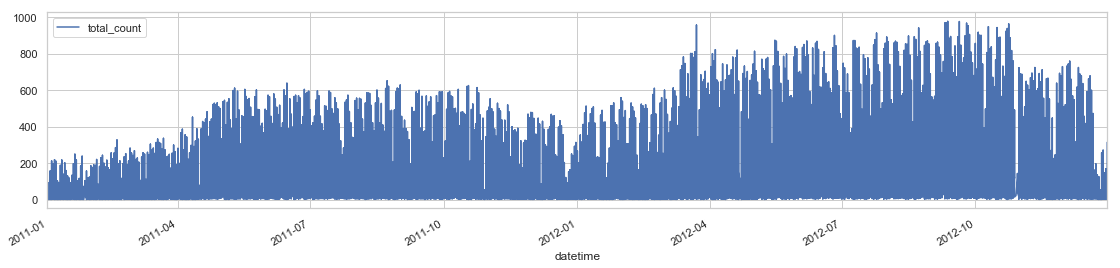

In [432]:
X = data[['datetime', 'total_count']].set_index(['datetime'])
X.plot(figsize=(19, 4))
plt.show()

In [433]:
data.head()

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


##  Statistical Models

Autoregressive Integrated Moving Average (ARIMA), is a forecasting method for univariate time series data. The integrated element refers to differencing allowing the method to support time series data with a trend. A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

Seasonal Autoregressive Integrated Moving Average (SARIMA) or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series. SARIMA(p,d,q)(P,D,Q)m

Trend Elements
There are three trend elements that require configuration.

They are the same as the ARIMA model:

    p: Trend autoregression order.
    d: Trend difference order.
    q: Trend moving average order.
    Seasonal Elements
    There are four seasonal elements that are not part of ARIMA that must be configured; they are:

    P: Seasonal autoregressive order.
    D: Seasonal difference order.
    Q: Seasonal moving average order.
    m: The number of time steps for a single seasonal period.
    
SARIMA (SARIMAX extended version) is used for non-stationary series, that is, where the data do not fluctuate around the same mean, variance and co-variance. This model can identify trend and seasonality. 

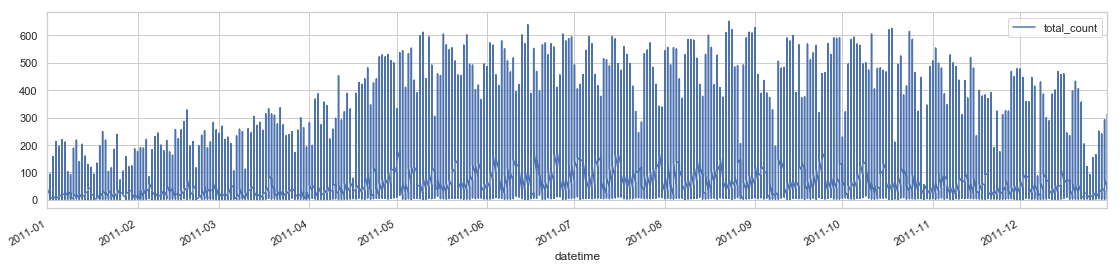

In [434]:
X = data.query("year==0")[['datetime', 'total_count']].set_index(['datetime'])
X.plot(figsize=(19, 4))
plt.show()

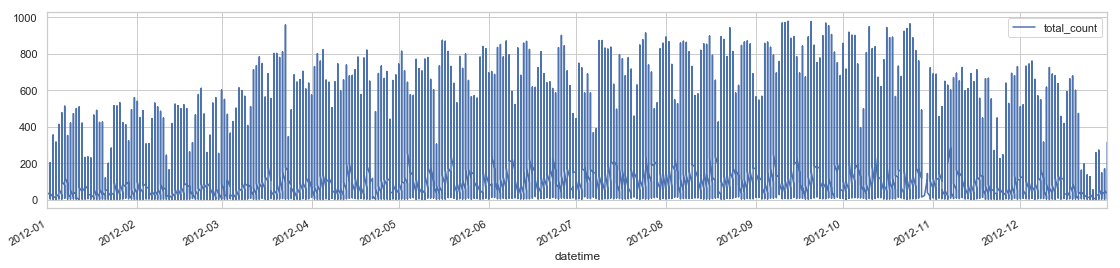

In [435]:
X = data.query("year==1")[['datetime', 'total_count']].set_index(['datetime'])
X.plot(figsize=(19, 4))
plt.show()

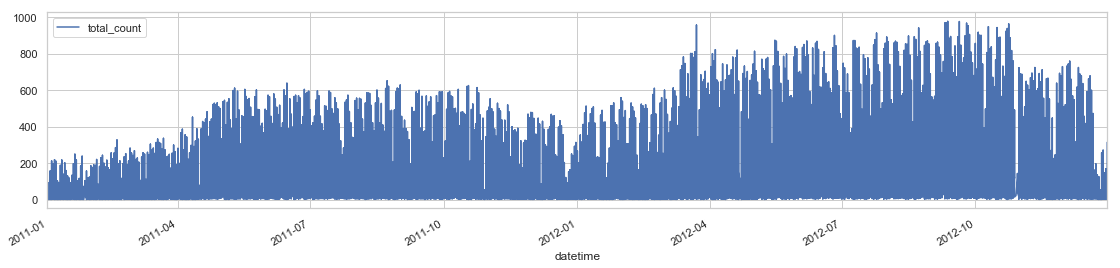

In [436]:
X = data[['datetime', 'total_count']].set_index(['datetime'])
X.plot(figsize=(19, 4))
plt.show()

In [437]:
print(data.query("year==1")[:8645].shape)
print(data.query("year==0").shape)

(8645, 17)
(8645, 17)


In [413]:
X = X.values.astype('float32')

In [414]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value[0])
        
    return Series(diff)

In [415]:
data.head()

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [420]:
X.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

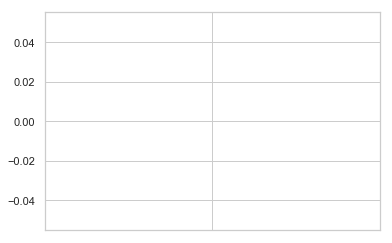

In [423]:
from pandas import Grouper

data.index = pd.to_datetime(data.index, unit='s')

groups = data['datetime'].groupby(Grouper(freq='A'))
years = pd.DataFrame()

for name, group in groups:
    years[name.year] = group.values

years.boxplot()
plt.show()

In [293]:
# difference data
months_in_year   = 12
stationary       = difference(X, months_in_year)
stationary.index = data.index[months_in_year:]

In [294]:
# check if stationary
result = adfuller(stationary)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.886864
p-value: 0.000000
Critical Values:
	5%: -2.862
	1%: -3.431
	10%: -2.567


The outputs of the result of a statistical significance test (augmented Dickey-Fuller test) of whether the differenced series is stationary.

The results show that the test statistic value -26.886864 is smaller than the critical value at 1% of -3.431. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. And this show that no obvious seasonality or trend, suggesting the seasonally differenced dataset is a good starting point for modeling.

In [295]:
# save
stationary.to_csv('stationary.csv', header=False)

We will use this dataset as an input to the ARIMA model. It also suggests that no further differencing may be required, and that the d parameter may be set to 0.

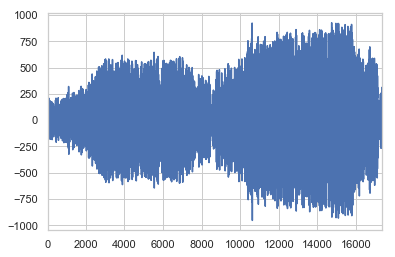

In [296]:
# plot
stationary.plot()
plt.show()

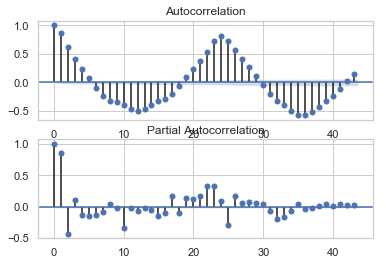

In [292]:
# load data
series = pd.read_csv('stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

plt.figure()
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

In [212]:
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()

In [214]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [215]:
# walk-forward validation
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    
    # define model
    model = ARIMA(diff, order=(1,1,1)) # seasonal_order=
    
    # predict
    model_fit = model.fit(trend='nc', disp=0)
    
    # one step forecast (takes a single parameter that specifies the number of out of sample time steps to forecast, or assumes a one step forecast if no arguments are provided. While predict requires a start and end date or index to be specified)
    yhat = model_fit.forecast()[0] 
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

>Predicted=87.656, Expected= 66
>Predicted=97.970, Expected= 39
>Predicted=79.090, Expected= 34
>Predicted=41.953, Expected= 13
>Predicted=-25.134, Expected=  6
>Predicted=-4.639, Expected=  3
>Predicted=22.826, Expected=  2
>Predicted=-21.393, Expected=  5
>Predicted=16.139, Expected= 12
>Predicted=-17.333, Expected= 85
>Predicted=97.691, Expected=170
>Predicted=195.385, Expected=354
>Predicted=401.485, Expected=153
>Predicted=12.558, Expected= 60
>Predicted=80.693, Expected= 75
>Predicted=50.428, Expected= 74
>Predicted=77.638, Expected= 73
>Predicted=67.506, Expected= 79
>Predicted=83.218, Expected= 77
>Predicted=77.021, Expected=136
>Predicted=169.380, Expected=245
>Predicted=350.607, Expected=224
>Predicted=251.320, Expected=156
>Predicted=299.891, Expected=115
>Predicted=-166.747, Expected= 68
>Predicted=82.705, Expected= 33
>Predicted=21.534, Expected= 18
>Predicted=16.501, Expected=  9
>Predicted=4.683, Expected=  3
>Predicted=8.386, Expected=  1
>Predicted=-4.261, Expected=  1

>Predicted=50.416, Expected=103
>Predicted=65.352, Expected=114
>Predicted=109.292, Expected=154
>Predicted=142.902, Expected=154
>Predicted=160.112, Expected=129
>Predicted=108.078, Expected=138
>Predicted=147.808, Expected=233
>Predicted=288.072, Expected=332
>Predicted=401.860, Expected=301
>Predicted=359.675, Expected=206
>Predicted=381.963, Expected=136
>Predicted=-175.076, Expected=102
>Predicted=117.812, Expected= 65
>Predicted=47.340, Expected= 65
>Predicted=114.005, Expected= 44
>Predicted=12.710, Expected= 50
>Predicted=42.783, Expected= 38
>Predicted=44.139, Expected= 20
>Predicted=104.460, Expected=  3
>Predicted=57.633, Expected=  4
>Predicted=-48.825, Expected=  5
>Predicted=-65.310, Expected= 24
>Predicted=-7.587, Expected= 92
>Predicted=100.387, Expected= 81
>Predicted=33.660, Expected=149
>Predicted=200.386, Expected=178
>Predicted=144.961, Expected=219
>Predicted=258.206, Expected=220
>Predicted=189.737, Expected=231
>Predicted=231.987, Expected=226
>Predicted=205.562

>Predicted=-32.415, Expected= 37
>Predicted=68.119, Expected= 25
>Predicted=-20.293, Expected=  9
>Predicted=46.749, Expected=  8
>Predicted=3.366, Expected=  3
>Predicted=51.584, Expected=  2
>Predicted=134.153, Expected= 26
>Predicted=-14.682, Expected= 89
>Predicted=74.598, Expected=232
>Predicted=248.269, Expected=490
>Predicted=544.665, Expected=255
>Predicted=71.241, Expected=116
>Predicted=110.275, Expected=153
>Predicted=158.701, Expected=175
>Predicted=165.412, Expected=203
>Predicted=218.258, Expected=173
>Predicted=147.401, Expected=208
>Predicted=234.530, Expected=278
>Predicted=319.942, Expected=515
>Predicted=663.037, Expected=423
>Predicted=456.905, Expected=331
>Predicted=538.350, Expected=229
>Predicted=-139.956, Expected=172
>Predicted=175.570, Expected=125
>Predicted=133.761, Expected= 99
>Predicted=106.956, Expected= 31
>Predicted=26.257, Expected= 13
>Predicted=-21.429, Expected=  6
>Predicted=53.231, Expected=  1
>Predicted=47.547, Expected=  4
>Predicted=222.877,

>Predicted=129.232, Expected=129
>Predicted=85.289, Expected=164
>Predicted=174.983, Expected=216
>Predicted=216.342, Expected=198
>Predicted=173.327, Expected=170
>Predicted=166.930, Expected=216
>Predicted=235.358, Expected=311
>Predicted=357.931, Expected=488
>Predicted=614.127, Expected=385
>Predicted=421.142, Expected=267
>Predicted=419.468, Expected=163
>Predicted=-116.821, Expected=134
>Predicted=106.531, Expected=119
>Predicted=154.533, Expected= 77
>Predicted=95.321, Expected= 86
>Predicted=65.406, Expected= 43
>Predicted=5.381, Expected= 44
>Predicted=107.187, Expected= 18
>Predicted=73.528, Expected=  6
>Predicted=155.377, Expected=  4
>Predicted=-163.568, Expected=  5
>Predicted=-37.039, Expected= 28
>Predicted=-51.042, Expected= 90
>Predicted=121.180, Expected=157
>Predicted=154.982, Expected=224
>Predicted=211.426, Expected=270
>Predicted=303.191, Expected=300
>Predicted=254.581, Expected=302
>Predicted=323.705, Expected=276
>Predicted=228.392, Expected=305
>Predicted=327

>Predicted=112.357, Expected=102
>Predicted=112.113, Expected= 36
>Predicted=31.335, Expected= 14
>Predicted=29.916, Expected=  6
>Predicted=-9.121, Expected=  3
>Predicted=28.715, Expected=  3
>Predicted=47.575, Expected=  2
>Predicted=178.705, Expected= 22
>Predicted=-47.240, Expected= 90
>Predicted=10.581, Expected=280
>Predicted=345.309, Expected=513
>Predicted=513.908, Expected=262
>Predicted=104.516, Expected= 98
>Predicted=34.151, Expected=112
>Predicted=123.739, Expected=172
>Predicted=183.483, Expected=173
>Predicted=164.578, Expected=124
>Predicted=106.598, Expected=145
>Predicted=161.468, Expected=266
>Predicted=330.675, Expected=523
>Predicted=672.677, Expected=406
>Predicted=476.511, Expected=281
>Predicted=434.329, Expected=184
>Predicted=-172.460, Expected=109
>Predicted=71.962, Expected= 77
>Predicted=87.594, Expected= 57
>Predicted=103.854, Expected= 22
>Predicted=-12.011, Expected=  5
>Predicted=-35.062, Expected=  4
>Predicted=41.592, Expected=  3
>Predicted=106.488,

>Predicted=137.132, Expected=163
>Predicted=133.042, Expected=228
>Predicted=240.891, Expected=183
>Predicted=142.951, Expected= 31
>Predicted=-16.467, Expected= 94
>Predicted=141.222, Expected=178
>Predicted=215.692, Expected=256
>Predicted=328.906, Expected=300
>Predicted=476.650, Expected=233
>Predicted=324.607, Expected=167
>Predicted=-121.792, Expected=152
>Predicted=171.021, Expected=106
>Predicted=94.087, Expected= 86
>Predicted=149.056, Expected= 61
>Predicted=-22.201, Expected= 46
>Predicted=-74.579, Expected= 38
>Predicted=148.505, Expected=  7
>Predicted=27.275, Expected=  2
>Predicted=71.976, Expected=  3
>Predicted=17.382, Expected= 13
>Predicted=-54.530, Expected= 23
>Predicted=-9.263, Expected= 93
>Predicted=120.908, Expected=122
>Predicted=74.485, Expected=183
>Predicted=210.263, Expected=210
>Predicted=182.696, Expected=258
>Predicted=275.855, Expected=226
>Predicted=194.801, Expected=216
>Predicted=195.292, Expected=232
>Predicted=242.486, Expected=195
>Predicted=174.

>Predicted=79.560, Expected= 31
>Predicted=44.705, Expected=  8
>Predicted=-23.933, Expected=  6
>Predicted=27.674, Expected=  4
>Predicted=-4.903, Expected=  1
>Predicted=84.075, Expected=  3
>Predicted=144.739, Expected= 25
>Predicted=-37.196, Expected=102
>Predicted=15.663, Expected=275
>Predicted=337.394, Expected=501
>Predicted=507.780, Expected=233
>Predicted=68.828, Expected=129
>Predicted=113.872, Expected=130
>Predicted=112.465, Expected=138
>Predicted=146.801, Expected=164
>Predicted=168.937, Expected=136
>Predicted=118.400, Expected=166
>Predicted=189.317, Expected=250
>Predicted=297.274, Expected=446
>Predicted=586.242, Expected=457
>Predicted=571.009, Expected=287
>Predicted=392.724, Expected=187
>Predicted=-164.562, Expected=148
>Predicted=183.411, Expected=106
>Predicted=66.813, Expected= 54
>Predicted=58.378, Expected= 15
>Predicted=22.384, Expected=  5
>Predicted=-29.640, Expected=  4
>Predicted=48.893, Expected=  3
>Predicted=66.404, Expected=  3
>Predicted=172.516, E

>Predicted=130.628, Expected=180
>Predicted=134.852, Expected=207
>Predicted=197.447, Expected=294
>Predicted=304.021, Expected=260
>Predicted=216.671, Expected=202
>Predicted=195.566, Expected=107
>Predicted=68.294, Expected=129
>Predicted=186.556, Expected=258
>Predicted=355.066, Expected=408
>Predicted=608.853, Expected=296
>Predicted=441.338, Expected=235
>Predicted=-99.213, Expected=152
>Predicted=134.531, Expected=148
>Predicted=175.391, Expected=126
>Predicted=191.252, Expected=100
>Predicted=26.896, Expected= 69
>Predicted=31.415, Expected= 42
>Predicted=-49.328, Expected= 26
>Predicted=80.970, Expected=  2
>Predicted=94.663, Expected=  8
>Predicted=121.621, Expected= 30
>Predicted=-120.568, Expected= 86
>Predicted=117.741, Expected=218
>Predicted=174.641, Expected=321
>Predicted=379.520, Expected=443
>Predicted=445.957, Expected=585
>Predicted=619.037, Expected=651
>Predicted=631.218, Expected=686
>Predicted=682.593, Expected=690
>Predicted=652.241, Expected=679
>Predicted=656

>Predicted=577.553, Expected=221
>Predicted=-305.114, Expected=186
>Predicted=280.929, Expected= 93
>Predicted=25.149, Expected= 48
>Predicted=163.201, Expected= 10
>Predicted=-36.319, Expected=  5
>Predicted=-57.743, Expected=  7
>Predicted=40.686, Expected=  4
>Predicted=68.564, Expected=  3
>Predicted=333.777, Expected= 17
>Predicted=-101.876, Expected=101
>Predicted=-29.281, Expected=286
>Predicted=184.140, Expected=581
>Predicted=715.960, Expected=267
>Predicted=-31.694, Expected=138
>Predicted=176.908, Expected=175
>Predicted=132.425, Expected=220
>Predicted=253.833, Expected=211
>Predicted=192.382, Expected=184
>Predicted=178.213, Expected=200
>Predicted=208.739, Expected=305
>Predicted=361.057, Expected=614
>Predicted=807.829, Expected=644
>Predicted=751.866, Expected=417
>Predicted=567.569, Expected=294
>Predicted=-134.632, Expected=221
>Predicted=254.052, Expected=134
>Predicted=110.851, Expected= 64
>Predicted=91.021, Expected= 30
>Predicted=-5.125, Expected=  8
>Predicted=-

>Predicted=-131.745, Expected=246
>Predicted=164.586, Expected=508
>Predicted=577.912, Expected=376
>Predicted=257.053, Expected=238
>Predicted=242.874, Expected=291
>Predicted=217.998, Expected=337
>Predicted=348.254, Expected=411
>Predicted=379.002, Expected=490
>Predicted=523.575, Expected=537
>Predicted=538.398, Expected=536
>Predicted=552.755, Expected=655
>Predicted=757.251, Expected=484
>Predicted=573.393, Expected=412
>Predicted=628.193, Expected=252
>Predicted=-44.474, Expected=190
>Predicted=203.311, Expected=158
>Predicted=204.485, Expected=113
>Predicted=247.695, Expected= 94
>Predicted=60.410, Expected= 69
>Predicted=225.386, Expected= 36
>Predicted=-27.394, Expected= 28
>Predicted=120.332, Expected=  7
>Predicted=27.236, Expected=  2
>Predicted=-107.805, Expected= 19
>Predicted=-57.693, Expected= 54
>Predicted=-111.234, Expected=123
>Predicted=93.004, Expected=276
>Predicted=288.872, Expected=363
>Predicted=321.303, Expected=495
>Predicted=525.657, Expected=590
>Predicted

>Predicted=928.974, Expected=676
>Predicted=812.283, Expected=522
>Predicted=606.862, Expected=375
>Predicted=-23.918, Expected=271
>Predicted=333.665, Expected=214
>Predicted=182.278, Expected=121
>Predicted=115.910, Expected= 43
>Predicted=3.390, Expected= 11
>Predicted=40.629, Expected=  4
>Predicted=-25.553, Expected=  6
>Predicted=103.746, Expected=  9
>Predicted=320.078, Expected= 30
>Predicted=-134.045, Expected=144
>Predicted=119.154, Expected=461
>Predicted=461.742, Expected=673
>Predicted=657.833, Expected=400
>Predicted=224.236, Expected=217
>Predicted=125.366, Expected=239
>Predicted=211.777, Expected=244
>Predicted=224.442, Expected=239
>Predicted=238.030, Expected=257
>Predicted=267.254, Expected=308
>Predicted=328.912, Expected=370
>Predicted=408.690, Expected=781
>Predicted=1060.950, Expected=775
>Predicted=957.798, Expected=537
>Predicted=566.069, Expected=402
>Predicted=62.646, Expected=297
>Predicted=221.529, Expected=162
>Predicted=153.157, Expected= 82
>Predicted=5

>Predicted=264.093, Expected= 19
>Predicted=20.316, Expected=120
>Predicted=-16.014, Expected=315
>Predicted=244.993, Expected=592
>Predicted=618.344, Expected=334
>Predicted=148.362, Expected=236
>Predicted=273.472, Expected=233
>Predicted=106.918, Expected=307
>Predicted=390.034, Expected=306
>Predicted=183.985, Expected=300
>Predicted=391.474, Expected=324
>Predicted=230.308, Expected=440
>Predicted=583.470, Expected=702
>Predicted=749.120, Expected=654
>Predicted=857.174, Expected=441
>Predicted=585.611, Expected=289
>Predicted=-99.217, Expected=208
>Predicted=163.083, Expected=158
>Predicted=106.643, Expected=116
>Predicted=196.073, Expected=103
>Predicted=59.888, Expected= 67
>Predicted=65.818, Expected= 57
>Predicted=76.847, Expected= 26
>Predicted=119.276, Expected=  2
>Predicted=196.193, Expected=  5
>Predicted=-134.251, Expected= 28
>Predicted=-108.494, Expected= 55
>Predicted=-26.349, Expected=158
>Predicted=157.320, Expected=214
>Predicted=186.481, Expected=291
>Predicted=2

>Predicted=226.810, Expected=262
>Predicted=275.289, Expected=388
>Predicted=459.256, Expected=769
>Predicted=1025.976, Expected=680
>Predicted=761.988, Expected=546
>Predicted=708.613, Expected=323
>Predicted=-136.781, Expected=247
>Predicted=266.121, Expected=173
>Predicted=147.520, Expected=113
>Predicted=149.239, Expected= 38
>Predicted=-2.612, Expected=  9
>Predicted=-16.954, Expected= 16
>Predicted=53.593, Expected=  6
>Predicted=110.019, Expected=  5
>Predicted=339.474, Expected= 20
>Predicted=-211.347, Expected=165
>Predicted=205.597, Expected=463
>Predicted=349.455, Expected=641
>Predicted=692.501, Expected=295
>Predicted=37.365, Expected=157
>Predicted=157.513, Expected=217
>Predicted=166.545, Expected=263
>Predicted=276.523, Expected=219
>Predicted=198.551, Expected= 71
>Predicted=4.568, Expected=134
>Predicted=193.336, Expected=389
>Predicted=489.906, Expected=717
>Predicted=961.204, Expected=710
>Predicted=891.287, Expected=458
>Predicted=444.921, Expected=302
>Predicted=-

>Predicted=11.809, Expected= 49
>Predicted=10.198, Expected= 21
>Predicted=71.294, Expected= 14
>Predicted=101.776, Expected= 11
>Predicted=392.578, Expected= 34
>Predicted=-111.905, Expected=182
>Predicted=-9.846, Expected=515
>Predicted=658.185, Expected=745
>Predicted=629.544, Expected=361
>Predicted=189.530, Expected=255
>Predicted=204.086, Expected=334
>Predicted=296.024, Expected=360
>Predicted=366.155, Expected=395
>Predicted=379.212, Expected=350
>Predicted=329.263, Expected=391
>Predicted=416.615, Expected=568
>Predicted=659.024, Expected=812
>Predicted=1027.415, Expected=669
>Predicted=836.353, Expected=483
>Predicted=557.508, Expected=337
>Predicted=-142.455, Expected=258
>Predicted=337.958, Expected=251
>Predicted=284.010, Expected=174
>Predicted=151.415, Expected=148
>Predicted=183.112, Expected=104
>Predicted=22.901, Expected= 69
>Predicted=132.273, Expected= 33
>Predicted=163.946, Expected= 14
>Predicted=191.170, Expected= 12
>Predicted=-210.486, Expected= 50
>Predicted=

>Predicted=414.845, Expected=476
>Predicted=472.650, Expected=525
>Predicted=542.187, Expected=556
>Predicted=550.629, Expected=465
>Predicted=395.506, Expected=460
>Predicted=478.830, Expected=501
>Predicted=513.230, Expected=405
>Predicted=366.021, Expected=383
>Predicted=439.339, Expected=395
>Predicted=462.353, Expected=317
>Predicted=358.895, Expected=247
>Predicted=298.650, Expected=157
>Predicted=205.448, Expected= 82
>Predicted=76.225, Expected= 45
>Predicted=63.322, Expected= 14
>Predicted=-99.277, Expected=  8
>Predicted=52.967, Expected=  3
>Predicted=19.523, Expected=  5
>Predicted=-96.926, Expected= 33
>Predicted=70.870, Expected=154
>Predicted=202.368, Expected=450
>Predicted=484.703, Expected=634
>Predicted=629.239, Expected=257
>Predicted=-6.005, Expected=183
>Predicted=200.075, Expected=197
>Predicted=155.728, Expected=237
>Predicted=243.432, Expected=239
>Predicted=229.807, Expected=238
>Predicted=236.860, Expected=256
>Predicted=266.668, Expected=393
>Predicted=478.7

>Predicted=94.245, Expected=313
>Predicted=288.580, Expected=228
>Predicted=223.854, Expected=177
>Predicted=255.223, Expected= 77
>Predicted=-25.982, Expected= 29
>Predicted=6.929, Expected= 19
>Predicted=91.759, Expected=  8
>Predicted=102.041, Expected= 10
>Predicted=371.506, Expected= 29
>Predicted=-184.569, Expected=139
>Predicted=82.519, Expected=428
>Predicted=459.409, Expected=700
>Predicted=641.996, Expected=382
>Predicted=173.278, Expected=249
>Predicted=236.772, Expected=264
>Predicted=175.469, Expected=369
>Predicted=410.396, Expected=416
>Predicted=405.960, Expected=373
>Predicted=346.718, Expected=397
>Predicted=422.768, Expected=523
>Predicted=587.780, Expected=793
>Predicted=996.843, Expected=723
>Predicted=882.290, Expected=555
>Predicted=679.020, Expected=408
>Predicted=-31.550, Expected=339
>Predicted=381.433, Expected=291
>Predicted=258.918, Expected=215
>Predicted=301.030, Expected=206
>Predicted=209.486, Expected=123
>Predicted=41.161, Expected= 89
>Predicted=136.

>Predicted=-60.984, Expected=145
>Predicted=152.068, Expected=474
>Predicted=565.231, Expected=250
>Predicted=6.718, Expected= 91
>Predicted=89.140, Expected=121
>Predicted=66.636, Expected=168
>Predicted=188.708, Expected=225
>Predicted=235.610, Expected=219
>Predicted=205.869, Expected=237
>Predicted=256.677, Expected=332
>Predicted=380.595, Expected=723
>Predicted=895.167, Expected=642
>Predicted=628.289, Expected=463
>Predicted=718.565, Expected=362
>Predicted=-25.699, Expected=273
>Predicted=256.906, Expected=164
>Predicted=147.118, Expected= 74
>Predicted=88.340, Expected= 35
>Predicted=68.123, Expected= 14
>Predicted=-16.480, Expected= 15
>Predicted=48.261, Expected=  8
>Predicted=83.909, Expected= 10
>Predicted=367.210, Expected= 37
>Predicted=-196.385, Expected=161
>Predicted=151.724, Expected=480
>Predicted=526.690, Expected=673
>Predicted=647.989, Expected=328
>Predicted=68.762, Expected=180
>Predicted=145.619, Expected=230
>Predicted=228.653, Expected=292
>Predicted=299.386

>Predicted=512.832, Expected=705
>Predicted=938.086, Expected=697
>Predicted=897.222, Expected=571
>Predicted=531.091, Expected=470
>Predicted=179.648, Expected=398
>Predicted=333.526, Expected=274
>Predicted=270.373, Expected=171
>Predicted=190.513, Expected=114
>Predicted=39.585, Expected= 42
>Predicted=62.089, Expected= 18
>Predicted=-37.624, Expected=  8
>Predicted=197.858, Expected= 10
>Predicted=239.770, Expected= 45
>Predicted=-51.406, Expected=163
>Predicted=139.463, Expected=380
>Predicted=388.348, Expected=624
>Predicted=658.978, Expected=300
>Predicted=5.576, Expected=171
>Predicted=149.884, Expected=188
>Predicted=146.446, Expected=226
>Predicted=190.648, Expected=239
>Predicted=236.512, Expected=233
>Predicted=220.756, Expected=230
>Predicted=236.373, Expected=351
>Predicted=439.327, Expected=539
>Predicted=701.981, Expected=464
>Predicted=568.779, Expected=363
>Predicted=514.191, Expected=308
>Predicted=-109.623, Expected=236
>Predicted=270.778, Expected=163
>Predicted=12

>Predicted=-13.824, Expected=  5
>Predicted=6.909, Expected=  2
>Predicted=-21.523, Expected= 28
>Predicted=34.174, Expected= 92
>Predicted=115.378, Expected=230
>Predicted=317.800, Expected=455
>Predicted=439.660, Expected=363
>Predicted=240.597, Expected=175
>Predicted=146.361, Expected=216
>Predicted=165.271, Expected=266
>Predicted=291.144, Expected=255
>Predicted=223.930, Expected=242
>Predicted=250.904, Expected=280
>Predicted=290.346, Expected=413
>Predicted=495.896, Expected=849
>Predicted=1076.389, Expected=872
>Predicted=910.408, Expected=631
>Predicted=728.220, Expected=447
>Predicted=226.947, Expected=331
>Predicted=194.875, Expected=224
>Predicted=277.269, Expected=131
>Predicted=112.368, Expected= 69
>Predicted=39.515, Expected= 15
>Predicted=-8.975, Expected= 16
>Predicted=65.949, Expected=  3
>Predicted=106.288, Expected=  4
>Predicted=392.984, Expected= 42
>Predicted=-97.811, Expected=187
>Predicted=83.118, Expected=520
>Predicted=536.543, Expected=649
>Predicted=580.4

>Predicted=258.935, Expected=254
>Predicted=232.966, Expected=197
>Predicted=178.134, Expected=292
>Predicted=349.121, Expected=358
>Predicted=392.703, Expected=771
>Predicted=1061.200, Expected=777
>Predicted=959.374, Expected=533
>Predicted=520.001, Expected=505
>Predicted=164.372, Expected=332
>Predicted=291.056, Expected= 68
>Predicted=-21.294, Expected= 65
>Predicted=166.644, Expected= 34
>Predicted=-49.688, Expected= 11
>Predicted=-15.644, Expected= 19
>Predicted=129.469, Expected= 36
>Predicted=57.546, Expected=  9
>Predicted=400.377, Expected= 42
>Predicted=-120.230, Expected=126
>Predicted=2.577, Expected=360
>Predicted=496.899, Expected=691
>Predicted=604.867, Expected=373
>Predicted=-2.668, Expected=233
>Predicted=344.099, Expected=212
>Predicted=115.622, Expected=274
>Predicted=327.360, Expected=156
>Predicted=81.247, Expected=229
>Predicted=317.803, Expected=216
>Predicted=139.123, Expected=436
>Predicted=609.967, Expected=715
>Predicted=844.489, Expected=622
>Predicted=75

>Predicted=423.281, Expected=148
>Predicted=146.967, Expected=100
>Predicted=83.353, Expected= 58
>Predicted=18.596, Expected= 19
>Predicted=58.488, Expected=  8
>Predicted=-36.697, Expected=  3
>Predicted=42.241, Expected=  5
>Predicted=-2.972, Expected= 47
>Predicted=-41.089, Expected=161
>Predicted=279.181, Expected=469
>Predicted=415.626, Expected=751
>Predicted=874.250, Expected=293
>Predicted=-106.422, Expected=189
>Predicted=286.480, Expected=215
>Predicted=135.676, Expected=278
>Predicted=306.530, Expected=226
>Predicted=175.544, Expected=254
>Predicted=286.738, Expected=236
>Predicted=213.269, Expected=425
>Predicted=566.669, Expected=827
>Predicted=1060.158, Expected=812
>Predicted=1000.800, Expected=665
>Predicted=793.062, Expected=462
>Predicted=-147.030, Expected=322
>Predicted=441.346, Expected=230
>Predicted=151.295, Expected=150
>Predicted=215.225, Expected= 38
>Predicted=-96.858, Expected= 21
>Predicted=106.276, Expected=  8
>Predicted=-57.437, Expected=  6
>Predicted=

>Predicted=124.087, Expected=475
>Predicted=450.062, Expected=698
>Predicted=691.274, Expected=353
>Predicted=43.660, Expected=205
>Predicted=187.610, Expected=260
>Predicted=222.903, Expected=277
>Predicted=262.544, Expected=281
>Predicted=275.032, Expected=247
>Predicted=225.662, Expected=267
>Predicted=290.707, Expected=417
>Predicted=506.691, Expected=810
>Predicted=1076.720, Expected=811
>Predicted=991.007, Expected=623
>Predicted=676.743, Expected=478
>Predicted=43.998, Expected=336
>Predicted=327.135, Expected=259
>Predicted=278.576, Expected=156
>Predicted=116.427, Expected= 85
>Predicted=75.688, Expected= 41
>Predicted=-8.931, Expected= 20
>Predicted=53.967, Expected=  9
>Predicted=137.563, Expected=  7
>Predicted=339.313, Expected= 33
>Predicted=-108.172, Expected= 44
>Predicted=-69.099, Expected=133
>Predicted=80.890, Expected=119
>Predicted=-7.460, Expected=220
>Predicted=249.315, Expected=193
>Predicted=60.924, Expected=251
>Predicted=269.867, Expected=315
>Predicted=289.9

>Predicted=357.587, Expected=343
>Predicted=344.790, Expected=377
>Predicted=413.293, Expected=341
>Predicted=389.696, Expected=274
>Predicted=366.351, Expected=190
>Predicted=263.236, Expected= 56
>Predicted=-192.727, Expected= 46
>Predicted=186.233, Expected= 26
>Predicted=-187.717, Expected= 10
>Predicted=91.517, Expected=  5
>Predicted=89.359, Expected=  3
>Predicted=43.355, Expected=  7
>Predicted=-22.229, Expected= 37
>Predicted=99.169, Expected=161
>Predicted=153.444, Expected=442
>Predicted=509.965, Expected=655
>Predicted=636.306, Expected=357
>Predicted=90.399, Expected=193
>Predicted=234.032, Expected=241
>Predicted=223.174, Expected=282
>Predicted=293.583, Expected=291
>Predicted=284.194, Expected=275
>Predicted=268.720, Expected=309
>Predicted=332.012, Expected=460
>Predicted=549.713, Expected=893
>Predicted=1177.038, Expected=815
>Predicted=922.639, Expected=299
>Predicted=222.595, Expected=261
>Predicted=-12.718, Expected=245
>Predicted=201.652, Expected=161
>Predicted=1

>Predicted=69.109, Expected= 17
>Predicted=28.569, Expected=  5
>Predicted=149.506, Expected=  8
>Predicted=318.859, Expected= 35
>Predicted=-154.734, Expected=163
>Predicted=145.859, Expected=532
>Predicted=493.797, Expected=754
>Predicted=758.328, Expected=396
>Predicted=145.394, Expected=234
>Predicted=201.346, Expected=276
>Predicted=218.023, Expected=294
>Predicted=286.903, Expected=290
>Predicted=284.687, Expected=273
>Predicted=255.500, Expected=338
>Predicted=379.837, Expected=482
>Predicted=556.095, Expected=844
>Predicted=1106.123, Expected=853
>Predicted=1100.323, Expected=610
>Predicted=604.472, Expected=471
>Predicted=55.255, Expected=307
>Predicted=264.507, Expected=291
>Predicted=342.833, Expected=152
>Predicted=80.139, Expected= 82
>Predicted=80.850, Expected= 32
>Predicted=-8.011, Expected= 20
>Predicted=98.665, Expected=  5
>Predicted=104.699, Expected=  7
>Predicted=324.074, Expected= 29
>Predicted=-99.678, Expected=108
>Predicted=-34.465, Expected=421
>Predicted=493

>Predicted=504.082, Expected=585
>Predicted=612.679, Expected=757
>Predicted=824.236, Expected=729
>Predicted=654.775, Expected=647
>Predicted=594.280, Expected=696
>Predicted=725.966, Expected=701
>Predicted=715.260, Expected=671
>Predicted=630.413, Expected=560
>Predicted=562.254, Expected=496
>Predicted=565.460, Expected=356
>Predicted=386.946, Expected=206
>Predicted=318.721, Expected=189
>Predicted=219.534, Expected= 92
>Predicted=205.069, Expected= 41
>Predicted=-63.182, Expected= 18
>Predicted=-24.221, Expected= 17
>Predicted=84.642, Expected= 12
>Predicted=-17.615, Expected=  5
>Predicted=-13.650, Expected= 40
>Predicted=-45.934, Expected=180
>Predicted=222.022, Expected=447
>Predicted=411.012, Expected=730
>Predicted=728.508, Expected=361
>Predicted=167.866, Expected=210
>Predicted=136.330, Expected=236
>Predicted=231.509, Expected=332
>Predicted=355.454, Expected=323
>Predicted=305.782, Expected=340
>Predicted=351.453, Expected=346
>Predicted=336.104, Expected=488
>Predicted=

>Predicted=613.360, Expected=409
>Predicted=-118.251, Expected=349
>Predicted=402.539, Expected=229
>Predicted=197.297, Expected=123
>Predicted=155.496, Expected= 58
>Predicted=-11.582, Expected= 18
>Predicted=29.938, Expected= 11
>Predicted=26.720, Expected=  6
>Predicted=151.354, Expected=  6
>Predicted=357.227, Expected= 56
>Predicted=-79.608, Expected=170
>Predicted=10.188, Expected=534
>Predicted=578.245, Expected=790
>Predicted=825.785, Expected=355
>Predicted=9.586, Expected=190
>Predicted=174.116, Expected=243
>Predicted=208.849, Expected=290
>Predicted=287.885, Expected=336
>Predicted=351.071, Expected=298
>Predicted=267.364, Expected=291
>Predicted=302.737, Expected=457
>Predicted=579.984, Expected=976
>Predicted=1276.584, Expected=900
>Predicted=1081.628, Expected=603
>Predicted=635.526, Expected=417
>Predicted=-117.354, Expected=274
>Predicted=296.891, Expected=287
>Predicted=331.507, Expected=154
>Predicted=116.866, Expected= 66
>Predicted=89.549, Expected= 49
>Predicted=-

>Predicted=-31.044, Expected= 10
>Predicted=-87.842, Expected= 22
>Predicted=-49.790, Expected= 57
>Predicted=-47.831, Expected=144
>Predicted=211.934, Expected=285
>Predicted=247.342, Expected=479
>Predicted=564.339, Expected=591
>Predicted=552.795, Expected=680
>Predicted=709.726, Expected=594
>Predicted=513.504, Expected=612
>Predicted=626.165, Expected=649
>Predicted=608.076, Expected=648
>Predicted=669.938, Expected=575
>Predicted=541.205, Expected=401
>Predicted=369.675, Expected=257
>Predicted=291.213, Expected=194
>Predicted=289.369, Expected=123
>Predicted=238.107, Expected= 91
>Predicted=133.900, Expected= 57
>Predicted=110.355, Expected= 45
>Predicted=-71.698, Expected= 18
>Predicted=79.511, Expected= 12
>Predicted=15.899, Expected=  7
>Predicted=2.311, Expected= 10
>Predicted=-59.252, Expected= 36
>Predicted=-92.427, Expected=155
>Predicted=128.780, Expected=483
>Predicted=587.831, Expected=784
>Predicted=804.295, Expected=340
>Predicted=83.874, Expected=179
>Predicted=194.

>Predicted=285.793, Expected=319
>Predicted=334.649, Expected=566
>Predicted=710.742, Expected=948
>Predicted=1195.028, Expected=844
>Predicted=1005.735, Expected=566
>Predicted=689.748, Expected=392
>Predicted=-220.687, Expected=269
>Predicted=357.399, Expected=197
>Predicted=190.078, Expected=136
>Predicted=210.427, Expected= 42
>Predicted=-131.414, Expected= 11
>Predicted=54.684, Expected= 11
>Predicted=36.873, Expected=  3
>Predicted=234.116, Expected= 10
>Predicted=284.708, Expected= 42
>Predicted=-176.740, Expected=159
>Predicted=44.003, Expected=478
>Predicted=509.680, Expected=798
>Predicted=810.235, Expected=355
>Predicted=62.174, Expected=204
>Predicted=214.733, Expected=251
>Predicted=173.204, Expected=326
>Predicted=368.080, Expected=291
>Predicted=252.786, Expected=348
>Predicted=386.339, Expected=460
>Predicted=501.594, Expected=481
>Predicted=502.540, Expected=827
>Predicted=1099.939, Expected=692
>Predicted=812.753, Expected=743
>Predicted=1032.939, Expected=415
>Predic

>Predicted=176.086, Expected=154
>Predicted=155.785, Expected=117
>Predicted=95.691, Expected=132
>Predicted=149.589, Expected= 41
>Predicted=-30.982, Expected= 21
>Predicted=86.608, Expected= 10
>Predicted=-236.889, Expected= 26
>Predicted=-24.278, Expected= 56
>Predicted=6.116, Expected=143
>Predicted=244.556, Expected=269
>Predicted=185.574, Expected=443
>Predicted=526.371, Expected=547
>Predicted=545.824, Expected=675
>Predicted=699.365, Expected=626
>Predicted=605.083, Expected=640
>Predicted=566.203, Expected=623
>Predicted=629.758, Expected=591
>Predicted=561.116, Expected=491
>Predicted=473.928, Expected=413
>Predicted=414.531, Expected=266
>Predicted=282.747, Expected=195
>Predicted=280.356, Expected=166
>Predicted=286.202, Expected=113
>Predicted=135.379, Expected= 66
>Predicted=162.260, Expected= 31
>Predicted=-80.013, Expected= 11
>Predicted=69.329, Expected=  5
>Predicted=-43.339, Expected=  6
>Predicted=-2.007, Expected=  7
>Predicted=-89.092, Expected= 46
>Predicted=32.2

>Predicted=289.998, Expected=202
>Predicted=180.804, Expected=120
>Predicted=142.547, Expected= 50
>Predicted=33.085, Expected= 24
>Predicted=-42.707, Expected= 10
>Predicted=64.306, Expected=  3
>Predicted=103.256, Expected=  7
>Predicted=306.321, Expected= 26
>Predicted=-118.659, Expected=122
>Predicted=13.226, Expected=357
>Predicted=363.981, Expected=687
>Predicted=810.534, Expected=382
>Predicted=109.485, Expected=204
>Predicted=170.319, Expected=221
>Predicted=174.552, Expected=292
>Predicted=321.910, Expected=294
>Predicted=265.806, Expected=262
>Predicted=253.386, Expected=306
>Predicted=335.229, Expected=421
>Predicted=480.719, Expected=638
>Predicted=808.757, Expected=522
>Predicted=618.549, Expected=374
>Predicted=588.882, Expected=221
>Predicted=-258.709, Expected=156
>Predicted=179.127, Expected=149
>Predicted=148.623, Expected=119
>Predicted=176.073, Expected=108
>Predicted=77.603, Expected= 89
>Predicted=62.934, Expected= 46
>Predicted=81.802, Expected= 28
>Predicted=117

>Predicted=613.215, Expected=397
>Predicted=255.380, Expected=266
>Predicted=247.498, Expected=367
>Predicted=363.971, Expected=419
>Predicted=425.498, Expected=420
>Predicted=407.026, Expected=444
>Predicted=445.697, Expected=382
>Predicted=351.341, Expected=434
>Predicted=493.890, Expected=596
>Predicted=691.215, Expected=551
>Predicted=676.388, Expected=353
>Predicted=475.470, Expected=304
>Predicted=81.158, Expected=155
>Predicted=60.351, Expected=112
>Predicted=237.186, Expected= 63
>Predicted=31.455, Expected= 23
>Predicted=21.093, Expected=  5
>Predicted=21.351, Expected= 11
>Predicted=-55.842, Expected=  5
>Predicted=86.133, Expected=  9
>Predicted=133.755, Expected= 18
>Predicted=-81.799, Expected= 50
>Predicted=-84.292, Expected=107
>Predicted=148.530, Expected=211
>Predicted=90.623, Expected=110
>Predicted=75.873, Expected= 94
>Predicted=53.542, Expected=155
>Predicted=163.367, Expected=196
>Predicted=192.941, Expected=218
>Predicted=235.773, Expected=203
>Predicted=181.180,

>Predicted=97.754, Expected= 44
>Predicted=59.468, Expected= 52
>Predicted=70.781, Expected= 46
>Predicted=134.203, Expected= 44
>Predicted=14.058, Expected= 36
>Predicted=77.072, Expected= 32
>Predicted=17.311, Expected= 13
>Predicted=-37.763, Expected=  5
>Predicted=33.458, Expected=  1
>Predicted=-60.790, Expected=  4
>Predicted=-37.825, Expected= 10
>Predicted=-6.574, Expected= 20
>Predicted=6.391, Expected= 77
>Predicted=118.571, Expected= 94
>Predicted=75.800, Expected=112
>Predicted=127.465, Expected=201
>Predicted=227.900, Expected=251
>Predicted=257.561, Expected=379
>Predicted=417.887, Expected=424
>Predicted=418.131, Expected=435
>Predicted=439.032, Expected=447
>Predicted=453.698, Expected=357
>Predicted=316.741, Expected=300
>Predicted=302.632, Expected=208
>Predicted=219.878, Expected=154
>Predicted=140.132, Expected=142
>Predicted=161.313, Expected= 98
>Predicted=156.725, Expected= 79
>Predicted=92.266, Expected= 67
>Predicted=183.424, Expected= 42
>Predicted=19.567, Exp

>Predicted=154.050, Expected=396
>Predicted=490.685, Expected=731
>Predicted=788.978, Expected=308
>Predicted=74.217, Expected=136
>Predicted=123.793, Expected=233
>Predicted=254.531, Expected=268
>Predicted=265.657, Expected=321
>Predicted=344.285, Expected=260
>Predicted=217.455, Expected=268
>Predicted=289.679, Expected=442
>Predicted=547.207, Expected=708
>Predicted=883.556, Expected=692
>Predicted=857.625, Expected=471
>Predicted=623.090, Expected=300
>Predicted=-274.461, Expected=221
>Predicted=287.279, Expected=144
>Predicted=169.222, Expected=102
>Predicted=106.075, Expected= 55
>Predicted=84.139, Expected= 25
>Predicted=-63.814, Expected=  8
>Predicted=50.629, Expected=  4
>Predicted=155.265, Expected=  7
>Predicted=202.712, Expected= 46
>Predicted=-43.608, Expected=153
>Predicted=26.763, Expected=502
>Predicted=556.076, Expected=721
>Predicted=717.299, Expected=336
>Predicted=76.135, Expected=156
>Predicted=154.825, Expected=207
>Predicted=184.242, Expected=312
>Predicted=342

>Predicted=480.028, Expected=550
>Predicted=663.385, Expected=466
>Predicted=642.823, Expected=348
>Predicted=503.652, Expected=241
>Predicted=-235.438, Expected=213
>Predicted=269.755, Expected=148
>Predicted=108.686, Expected=120
>Predicted=219.392, Expected= 47
>Predicted=-45.858, Expected= 26
>Predicted=32.436, Expected=  9
>Predicted=35.297, Expected= 12
>Predicted=127.146, Expected= 10
>Predicted=98.623, Expected= 34
>Predicted=-79.730, Expected=113
>Predicted=86.894, Expected=308
>Predicted=304.354, Expected=636
>Predicted=763.691, Expected=343
>Predicted=75.983, Expected=190
>Predicted=219.407, Expected=211
>Predicted=133.053, Expected=273
>Predicted=318.411, Expected=313
>Predicted=292.328, Expected=299
>Predicted=305.224, Expected=309
>Predicted=308.736, Expected=417
>Predicted=492.291, Expected=622
>Predicted=761.637, Expected=455
>Predicted=503.657, Expected=319
>Predicted=561.915, Expected=221
>Predicted=-232.280, Expected=172
>Predicted=213.194, Expected=138
>Predicted=12

>Predicted=73.793, Expected=  9
>Predicted=-98.042, Expected= 17
>Predicted=51.105, Expected= 30
>Predicted=-15.938, Expected= 66
>Predicted=99.059, Expected= 85
>Predicted=67.675, Expected=103
>Predicted=135.883, Expected=124
>Predicted=85.079, Expected=135
>Predicted=145.784, Expected= 70
>Predicted=32.647, Expected= 46
>Predicted=46.944, Expected= 33
>Predicted=24.268, Expected= 33
>Predicted=43.256, Expected= 26
>Predicted=25.742, Expected= 26
>Predicted=39.261, Expected= 18
>Predicted=43.909, Expected= 23
>Predicted=32.249, Expected= 22
>Predicted=35.301, Expected= 12
>Predicted=22.024, Expected= 11
>Predicted=16.954, Expected= 13
>Predicted=-53.791, Expected= 13
>Predicted=20.718, Expected=  7
>Predicted=-13.040, Expected=  1
>Predicted=7.779, Expected=  3
>Predicted=-6.381, Expected=  7
>Predicted=13.388, Expected=  6
>Predicted=-5.612, Expected= 11
>Predicted=23.942, Expected= 28
>Predicted=28.792, Expected= 32
>Predicted=23.492, Expected= 86
>Predicted=114.631, Expected=114
>P

In [218]:
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 169.235


In [ ]:
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

                 0
count  8690.000000
mean     -0.022786
std     169.244579
min    -623.638726
25%     -81.494501
50%      -0.162300
75%      84.609651
max     687.604865


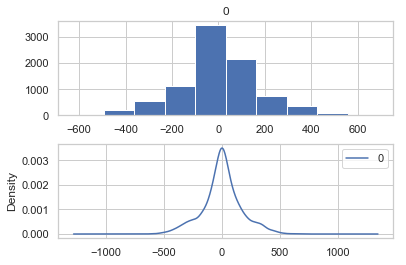

In [251]:
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

                 0
count  8690.000000
mean     -0.022786
std     169.244579
min    -623.638726
25%     -81.494501
50%      -0.162300
75%      84.609651
max     687.604865


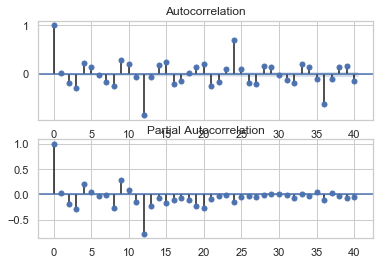

In [252]:
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

# plot
plt.figure()
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()

In [223]:
y = data[['datetime', 'total_count']].set_index(['datetime'])

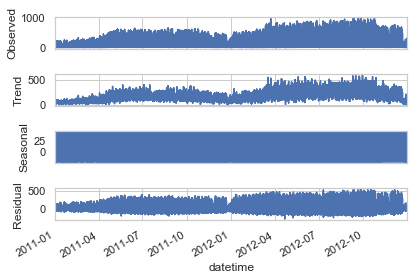

In [255]:
# assuming addtive ETS model
decomposition = sm.tsa.seasonal_decompose(y, model='additive', freq = 12)

fig = decomposition.plot()
plt.show()

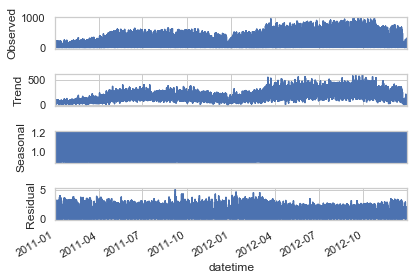

In [298]:
# assuming multplicative ETS model
decomposition = sm.tsa.seasonal_decompose(y, model='multiple', freq = 12)

fig = decomposition.plot()
plt.show()

In [300]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


AIC (Akaike information criterion) is an estimator of the relative quality of statistical models for a given set of data. AIC estimates the quality of each model, relative to each of the other models. The low AIC value the better.

In [301]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMAX{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:242891.400411
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:241324.470931
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:244235.139278
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:225595.536276
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:238725.620705
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:225748.258884
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:211738.554097
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:211320.966188
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:223893.799469
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:222720.403125
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:227084.942489
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:209903.953783
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:220999.98959
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:210045.632998
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:200009.036919
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:199893.199502
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:209840.051753
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:209441.950986
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:224749.579268
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 -

Our output suggests that ARIMAX(1, 0, 1)x(1, 1, 1, 12)12 with AIC value of 195761.478142 is the best combination, so we should consider this to be optimal option.

In [302]:
# SARIMAX : (1, 0, 1) x (1, 1, 1, 12)
param=(0, 0, 1)
param_seasonal=(1, 1, 1, 12)
mod = sm.tsa.statespace.SARIMAX(y,
                                order=param,seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:199893.199502


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:199893.199502.

In [303]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7169      0.004    176.306      0.000       0.709       0.725
ar.S.L12      -0.9188      0.003   -312.354      0.000      -0.925      -0.913
ma.S.L12       0.1035      0.009     11.849      0.000       0.086       0.121
sigma2      5889.5454     37.053    158.949      0.000    5816.923    5962.168


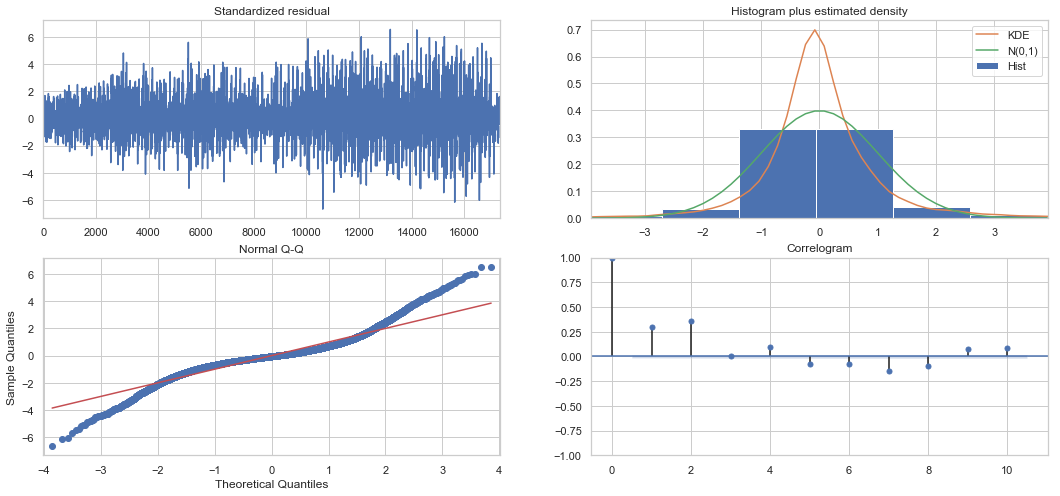

In [304]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

 Auto correlation function ACF (correlogram). Values upward the “0” has some correlation over the time series data. Values near to “1” demonstrates strongest correlation.

In [305]:
data.head()

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### One-step ahead Forecasting

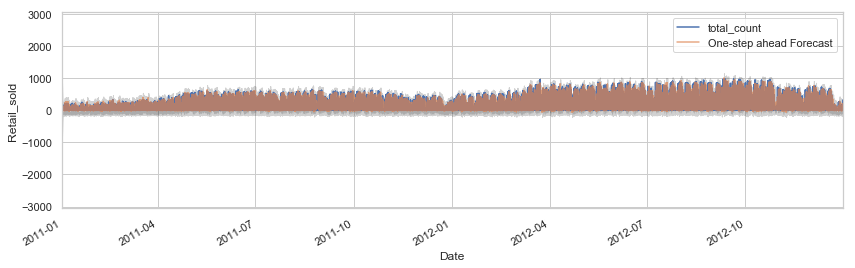

In [306]:
pred = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2011':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

This step consists in comparing the true values with the forecast predictions. Our forecasts fit with the true values very well. The command “pred = results.get_prediction(start=pd.to_datetime(‘2011-01-01’)” determines the period which you would forecast in comparing wiht the true data.

In [455]:
y_forecasted = pred.predicted_mean
y_truth = y['2011-01-01	':]

mse = ((y_forecasted.values - y_truth.values) ** 2).mean()

print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 60948.52
The Root Mean Squared Error is 246.88


Obs: In both MSE and RMSE, values closer to zero are better. They are a measure of accuracy.

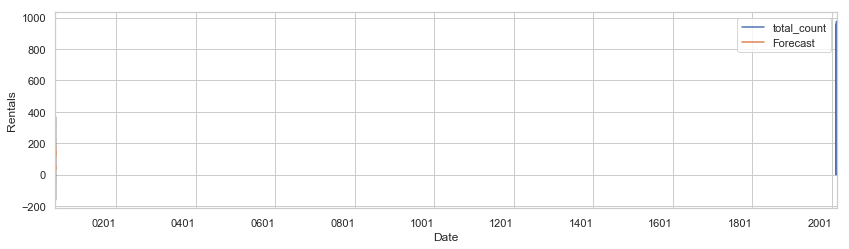

In [454]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 4))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Rentals')
plt.legend()
plt.show()

Here we forecast the sales for the next 12 months.

In [446]:
pred_uc.conf_int()

,lower total_count,upper total_count
17379,-90.852115,209.976382
17380,-146.032860,224.118858
17381,-144.367750,225.783968
17382,-138.825914,231.325804
17383,-155.312754,214.838964
17384,-158.238895,211.912823
17385,-138.226738,231.924980
17386,-96.091467,274.060252
17387,1.249383,371.401101
17388,-30.923453,339.228265


In [447]:
pred_ci.iloc[:, 0]

17379    -90.852115
17380   -146.032860
17381   -144.367750
17382   -138.825914
17383   -155.312754
17384   -158.238895
17385   -138.226738
17386    -96.091467
17387      1.249383
17388    -30.923453
17389    -68.075465
17390    -38.057671
Name: lower total_count, dtype: float64

In [448]:
pred_ci.iloc[:, 1]

17379    209.976382
17380    224.118858
17381    225.783968
17382    231.325804
17383    214.838964
17384    211.912823
17385    231.924980
17386    274.060252
17387    371.401101
17388    339.228265
17389    302.076253
17390    332.094047
Name: upper total_count, dtype: float64

In [449]:
pred_ci.index

Int64Index([17379, 17380, 17381, 17382, 17383, 17384, 17385, 17386, 17387,
            17388, 17389, 17390],
           dtype='int64')

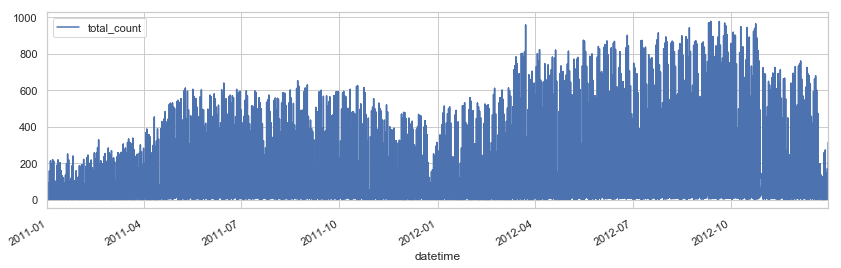

In [450]:
y.plot(label='observed', figsize=(14, 4))

Here we forecast the sales for the next 12 months. This parameter can me modified in the line “pred_uc = results.get_forecast(steps=12)”.

In [458]:
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

datetime
2011-01-01    0.000000
2011-01-01    0.000000
2011-01-01    0.084200
2011-01-01    0.067081
2011-01-01    0.027183
2011-01-01    0.002045
2011-01-01    0.002098
2011-01-01    0.004199
2011-01-01    0.006297
2011-01-01    0.016801
2011-01-01    0.029390
2011-01-01    0.075604
dtype: float64

This step indicate the predicted values of the test we have ran before.

In [459]:
y_truth.head(12)

,total_count
datetime,
2011-01-01,16
2011-01-01,40
2011-01-01,32
2011-01-01,13
2011-01-01,1
2011-01-01,1
2011-01-01,2
2011-01-01,3
2011-01-01,8


This step indicate the truth values of the data set. We can compare the two series above to measure the model accuracy.

In [461]:
pred_ci.head(24)

,lower total_count,upper total_count
17379,-90.852115,209.976382
17380,-146.032860,224.118858
17381,-144.367750,225.783968
17382,-138.825914,231.325804
17383,-155.312754,214.838964
17384,-158.238895,211.912823
17385,-138.226738,231.924980
17386,-96.091467,274.060252
17387,1.249383,371.401101
17388,-30.923453,339.228265


In the table above we can visualize the lower and upper values which the model indicate as boundaries for the forecasting.

In [460]:
forecast = pred_uc.predicted_mean
forecast.head(12)

17379     59.562134
17380     39.042999
17381     40.708109
17382     46.249945
17383     29.763105
17384     26.836964
17385     46.849121
17386     88.984393
17387    186.325242
17388    154.152406
17389    117.000394
17390    147.018188
dtype: float64

Finally here we have the sales forecasting for the next 12 months!